In [1]:
import pandas as pd
import numpy as np

# load DATE and TMAX
# review of data shows full data begins in 1948 so remove first 1082 lines corresponding to partial data between 1941 and 1947
# update the path for your own use
df = pd.read_csv('C:\\Users\\pjpardun\\Desktop\\weather\\USW00023232.csv',usecols=['DATE','TMAX'] , skiprows=[i for i in range(1, 1083) ])

# want only complete years, so drop partial 2022 data
df = df.drop(range(27029,27067))

In [2]:
# review of data shows 10/15/1994-10/31/1994, 12/30/2021, 1/21/2022-1/27/2022, 2/6/2022-2/7/2022 are null
# replace 10/15-10/31 of 1994 NaNs with 1993 values
index = 0
replace = df['TMAX'].iloc[16725:16742].tolist()

for i in range(17090,17107,1):
    df['TMAX'].iloc[i] = replace[index]
    index += 1

# replace 12/30 of 2021 NaN with 2020 value
df['TMAX'].iloc[27028] = df['TMAX'].iloc[26663]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [3]:
# reset index
df['TMAX'].replace('',np.nan,inplace=True)
df.dropna(subset = ['TMAX'], inplace=True)
df = df.reset_index(drop=True)

In [4]:
# temperature is recorded as Celsius without decimal point, add decimal and convert to Fahrenheit
df['TMAX'] = (df['TMAX'].div(10) * 9/5) + 32

In [5]:
# show first date
df.iloc[0]

DATE    1948-01-01
TMAX         53.96
Name: 0, dtype: object

In [6]:
# show last date
df.iloc[-1]

DATE    2021-12-31
TMAX         60.08
Name: 27025, dtype: object

In [7]:
# transform into np arrays for sinusoidal regression modeling
y_data_df = np.array(df['TMAX'].tolist(),dtype = np.float32)

# represent dates as continuous variable of same length
x_data_df = np.array(list(range(1,len(y_data_df) + 1)))

In [8]:
# define sinusoidal function
# a = amplitude, b = angular frequency, c / b = horizontal shift, d = distance or vertical shift
def test_func(x, a, b, c, d):
    return a * np.sin(b * (x + c)) + d


# define r-squared function
def r_func(y, y_predict):
    residuals = y - y_predict
    ss_residuals = np.sum(residuals**2)
    ss_total = np.sum((y-np.mean(y))**2)
    r_sq = 1 - (ss_residuals / ss_total)
    return r_sq

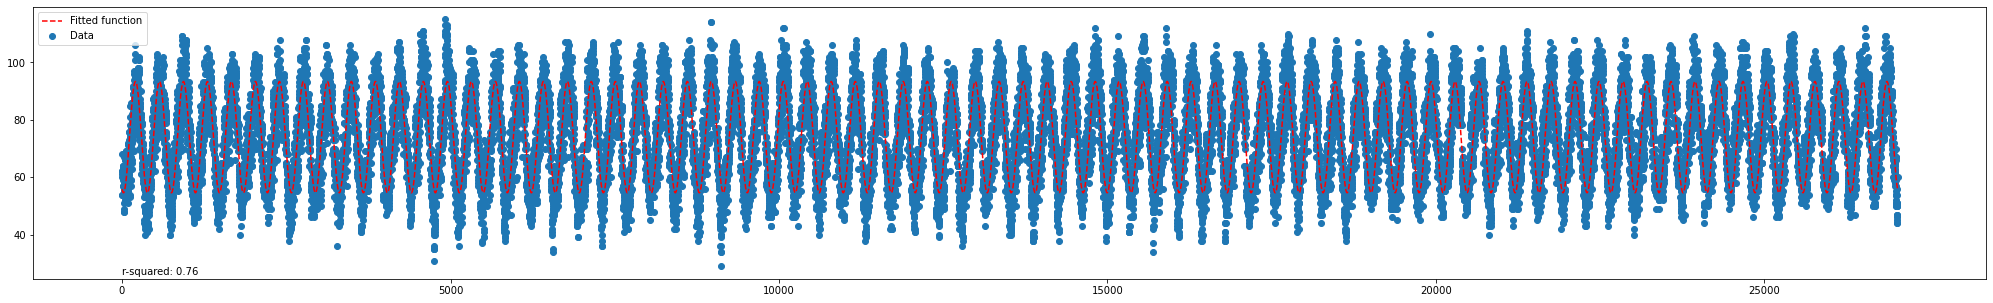

In [9]:
from scipy import optimize
import matplotlib.pyplot as plt

# perform regression and plot
# p0 are our best guess initial values
params, params_covariance = optimize.curve_fit(test_func, x_data_df, y_data_df, p0=[-1.04955965e+02, 1.72964061e-02, 2.97044441e+03, 2.43326360e+02])

# calculate coef of determination
r_sq = r_func(y_data_df, test_func(x_data_df, params[0], params[1], params[2], params[3]))
              
# plot
plt.figure(figsize = (35, 5))
plt.scatter(x_data_df, y_data_df, label = 'Data')
plt.plot(x_data_df, test_func(x_data_df, params[0], params[1], params[2], params[3]), 'r--',label = 'Fitted function')
plt.legend(loc = 'best')
plt.annotate('r-squared: '+str(round(r_sq,2)),xy=(0,26))
plt.show()

In [10]:
params

array([-1.93792659e+01,  1.72044884e-02,  2.99099116e+03,  7.39717617e+01])

In [11]:
r_sq

0.762452170754292

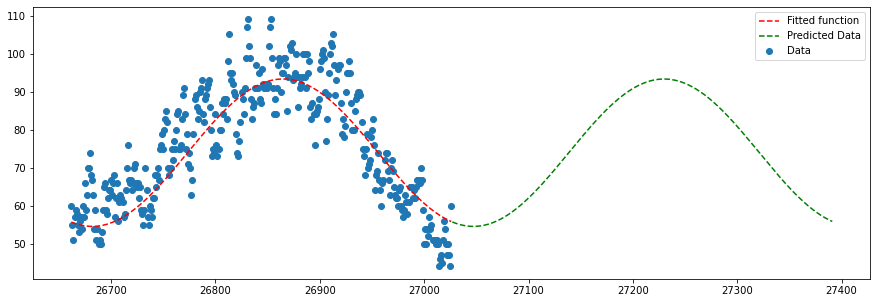

In [12]:
# display final year (2021) and extend to next year for prediction
import datetime
date1 = x_data_df[-1] + 1 # represents 1/1/2022
date2 = date1 + 365 # represents 12/31/2022

predict_x_data = np.arange(date1,date2,1)
predict_y_data = np.array(test_func(predict_x_data, params[0], params[1], params[2], params[3]))

plt.figure(figsize=(15, 5))
plt.scatter(x_data_df[26661:], y_data_df[26661:], label='Data')
plt.plot(x_data_df[26661:], test_func(x_data_df[26661:], params[0], params[1], params[2], params[3]), 'r--',label='Fitted function')
plt.plot(predict_x_data,predict_y_data, 'g--',label='Predicted Data')
plt.legend(loc='best')
plt.show()

In [13]:
# get hottest date
predict_x_data_date_objs = np.arange((np.datetime64('2022-01-01')), np.datetime64('2023-01-01')).tolist()

predict_x_data_dates = []
for date in predict_x_data_date_objs:
    predict_x_data_dates.append(date.strftime("%#m/%#d/%Y"))

predict_df = pd.DataFrame({'x_date': predict_x_data_dates,'y': predict_y_data.round(1)})

min, max = predict_df.loc[predict_df['y'].idxmin(), ['x_date','y']].tolist(), predict_df.loc[predict_df['y'].idxmax(), ['x_date','y']].tolist()

min, max

(['1/17/2022', 54.6], ['7/23/2022', 93.4])